## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [126]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [127]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# rows and columns of the data
print(data.shape)

# display data
data.head()

(1309, 14)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [128]:
# step: replace interrogation marks by NaN values
data = data.replace('?', np.nan)

In [129]:
data['cabin'].head()  # space sep

0         B5
1    C22 C26
2    C22 C26
3    C22 C26
4    C22 C26
Name: cabin, dtype: object

In [130]:
# step.
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
# apply works row by row. Best way to remember is (row) in function
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [131]:
# step
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [132]:
#step: cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [133]:
#step: drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [134]:
#save the data set

data.to_csv('./titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [135]:
target = 'survived'

In [136]:
vars_num = [var for var in data.columns if data[var].dtypes != 'O']  
vars_cat = [var for var in data.columns if data[var].dtypes == 'O']  

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [137]:
#step: first in numerical variables

vars_with_na = [
    var for var in vars_num
    if data[var].isnull().sum() > 0 and data[var].dtypes != 'O'
]

# print percentage of missing values per variable
data[vars_with_na].isnull().mean()



age     0.200917
fare    0.000764
dtype: float64

In [138]:
#step: now in categorical variables

vars_with_na = [
    var for var in vars_num
    if data[var].isnull().sum() > 0 and data[var].dtypes == 'O'
]

# print percentage of missing values per variable
data[vars_with_na].isnull().mean()

Series([], dtype: float64)

### Determine cardinality of categorical variables

In [139]:
# capture categorical variables in a list
cat_vars = [var for var in data.columns if data[var].dtypes == 'O']

print('Number of categorical variables: ', len(cat_vars))

# let's visualise the values of the categorical variables
data[cat_vars].head()

Number of categorical variables:  4


,sex,cabin,embarked,title
0,female,B5,S,Miss
1,male,C22,S,Master
2,female,C22,S,Miss
3,male,C22,S,Mr
4,female,C22,S,Mrs


In [140]:
data[cat_vars].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Extract only the letter (and drop the number) from the variable Cabin

In [141]:
# moving the cabin
data['cabin']=data['cabin'].str.slice(start=0,stop=1)

In [142]:
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)['survived'].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]

# print categories that are present in less than
# 1 % of the observations


for var in cat_vars:
    print(analyse_rare_labels(data, var, 0.05))
    print()

Series([], Name: survived, dtype: float64)

cabin
A    0.016807
B    0.049656
D    0.035141
E    0.031322
F    0.016043
G    0.003820
T    0.000764
Name: survived, dtype: float64

Series([], Name: survived, dtype: float64)

title
Master    0.046600
Other     0.023682
Name: survived, dtype: float64



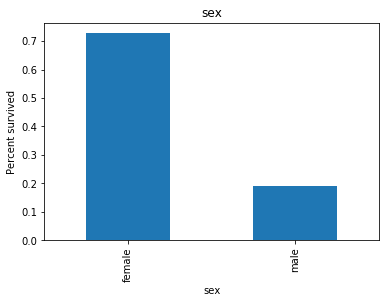

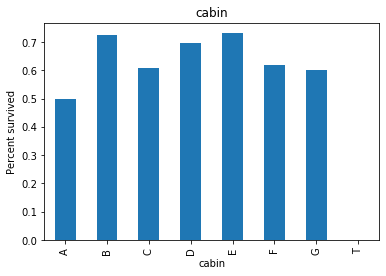

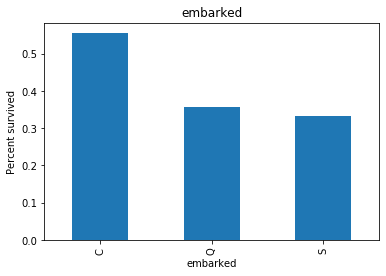

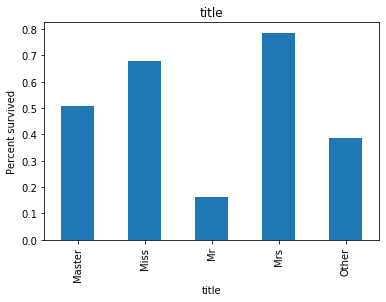

In [143]:
def analyse_categorical(df, var):
    df = df.copy()
    df.groupby(var)['survived'].mean().plot.bar()
    plt.title(var)
    plt.ylabel('Percent survived')
    plt.show()
    
for var in cat_vars:
    analyse_categorical(data, var)

### Determine the distribution of numerical variables

Number of continuous variables:  6


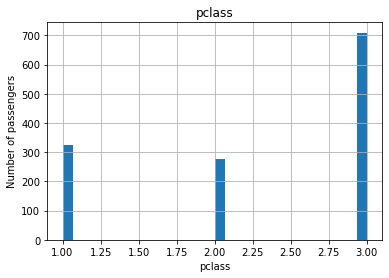

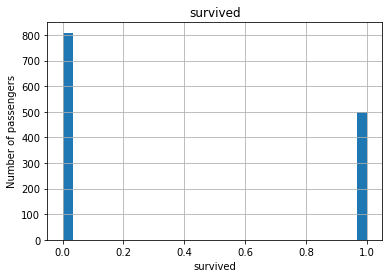

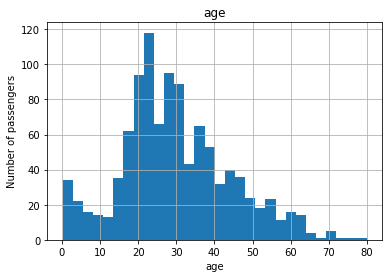

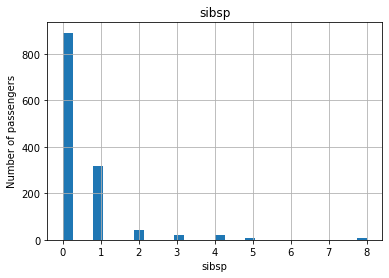

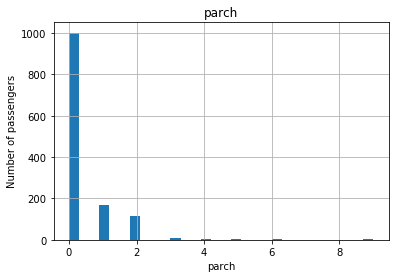

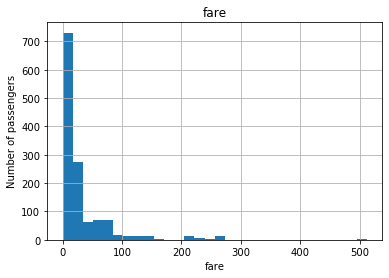

In [144]:
# make list of continuous variables

print('Number of continuous variables: ', len(vars_num))

def analyse_continuous(df, var):
    df = df.copy()
    df[var].hist(bins=30)
    plt.ylabel('Number of passengers')
    plt.xlabel(var)
    plt.title(var)
    plt.show()

for var in vars_num:
    analyse_continuous(data, var)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [336]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

In [337]:
X_test.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1139,3,male,38.0,0,0,7.8958,NaN,S,Mr
533,2,female,21.0,0,1,21.0000,NaN,S,Miss
459,2,male,42.0,1,0,27.0000,NaN,S,Mr
1150,3,male,NaN,0,0,14.5000,NaN,S,Mr
393,2,male,25.0,0,0,31.5000,NaN,S,Mr


## Feature Engineering

In [338]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1118,3,male,25.0,0,0,7.9250,NaN,S,Mr
44,1,female,41.0,0,0,134.5000,E,C,Miss
1072,3,male,NaN,0,0,7.7333,NaN,Q,Mr
1130,3,female,18.0,0,0,7.7750,NaN,S,Miss
574,2,male,29.0,1,0,21.0000,NaN,S,Mr


In [339]:
y_train.head()

1118    0
44      1
1072    0
1130    0
574     0
Name: survived, dtype: int64

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [340]:
# step this has to be done twice once for each dataset (in this case it does not matter)
vars_with_na = [
    var for var in X_train.columns
    if X_train[var].isnull().sum() > 0 and X_train[var].dtypes != 'O'
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().sum()
# X_test[vars_with_na].isnull().sum()

age     206
fare      1
dtype: int64

In [341]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1118,3,male,25.0,0,0,7.9250,NaN,S,Mr
44,1,female,41.0,0,0,134.5000,E,C,Miss
1072,3,male,NaN,0,0,7.7333,NaN,Q,Mr
1130,3,female,18.0,0,0,7.7750,NaN,S,Miss
574,2,male,29.0,1,0,21.0000,NaN,S,Mr


In [342]:
#step: replace engineer missing values as we described above

for var in vars_with_na:

    # calculate the mode using the train set
    median_val = X_train[var].median()

    # add binary missing indicator (in train and test)
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mode
    # (in train and test)
    X_train[var] = X_train[var].fillna(median_val)
    X_test[var] = X_test[var].fillna(median_val)

# check that we have no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

age     0
fare    0
dtype: int64

In [343]:
X_train[['age_na', 'fare_na']].sum()

age_na     206
fare_na      1
dtype: int64

In [344]:
#step only one missing fare, indicator function is silly

X_train.drop(labels=['fare_na'],axis=1,inplace=True)
X_test.drop(labels=['fare_na'],axis=1,inplace=True)

### Replace Missing data in categorical variables with the string **Missing**

In [345]:
#step make a list of the categorical variables that contain missing values

vars_with_na = [
    var for var in X_train.columns
    if X_train[var].isnull().sum() > 0 and X_train[var].dtypes == 'O'
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

cabin       0.766953
embarked    0.001910
dtype: float64

In [346]:
#step replace with missing training set
X_train[vars_with_na] = X_train[vars_with_na].fillna('Missing')

In [347]:
#step replace missing values with new label: "Missing" test set
vars_with_na = [
    var for var in X_test.columns
    if X_test[var].isnull().sum() > 0 and X_test[var].dtypes == 'O'
]


X_test[vars_with_na] = X_test[vars_with_na].fillna('Missing')

In [348]:
# X_train.head()

In [349]:
# check that we have no missing information in the engineered variables
X_test[vars_with_na].isnull().sum()

cabin    0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [350]:
# let's capture the categorical variables in a list

cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']
cat_vars

['sex', 'cabin', 'embarked', 'title']

In [351]:
#step

def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the people in the dataset

    df = df.copy()

    tmp = df.groupby(var)['sex'].count() / len(df)

    return tmp[tmp > rare_perc].index

for var in cat_vars:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

In [352]:
# this just prints out the counts

def analyse_rare_labels(df, var):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)['sex'].count() / len(df)

    # return categories that are rare
    return tmp

# print categories that are present in less than
# 1 % of the observations


for var in cat_vars:
    print(analyse_rare_labels(X_train, var))
    print()

sex
female    0.366762
male      0.633238
Name: sex, dtype: float64

cabin
C          0.074499
Missing    0.766953
Rare       0.158548
Name: sex, dtype: float64

embarked
C       0.195798
Q       0.092646
Rare    0.001910
S       0.709647
Name: sex, dtype: float64

title
Miss    0.200573
Mr      0.569245
Mrs     0.159503
Rare    0.070678
Name: sex, dtype: float64



### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [353]:
#step - need to pickle the model and apply it when predicting

enc = OneHotEncoder(handle_unknown = 'error',drop='first')
enc.fit(X_train[cat_vars])

OneHotEncoder(categories='auto', drop='first', dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [354]:
#step
train_dummies = pd.DataFrame(enc.transform(X_train[cat_vars]).toarray(), columns = enc.get_feature_names())
test_dummies = pd.DataFrame(enc.transform(X_test[cat_vars]).toarray(), columns = enc.get_feature_names())

In [355]:
test_dummies.head(10)

,x0_male,x1_Missing,x1_Rare,x2_Q,x2_Rare,x2_S,x3_Mr,x3_Mrs,x3_Rare
0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
9,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [356]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na
1118,3,male,25.0,0,0,7.9250,Missing,S,Mr,0
44,1,female,41.0,0,0,134.5000,Rare,C,Miss,0
1072,3,male,28.0,0,0,7.7333,Missing,Q,Mr,1
1130,3,female,18.0,0,0,7.7750,Missing,S,Miss,0
574,2,male,29.0,1,0,21.0000,Missing,S,Mr,0


In [357]:
print(train_dummies.shape)

(1047, 9)


In [358]:
print(X_train.shape)

(1047, 10)


In [359]:
#step
X_train = pd.concat([X_train.reset_index() ,train_dummies.reset_index()], axis=1)
X_test = pd.concat([X_test.reset_index(),test_dummies.reset_index()], axis=1)

In [360]:
print(X_train.shape)

(1047, 21)


In [361]:
X_train.head()

,index,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,index,x0_male,x1_Missing,x1_Rare,x2_Q,x2_Rare,x2_S,x3_Mr,x3_Mrs,x3_Rare
0,1118,3,male,25.0,0,0,7.9250,Missing,S,Mr,0,0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,44,1,female,41.0,0,0,134.5000,Rare,C,Miss,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1072,3,male,28.0,0,0,7.7333,Missing,Q,Mr,1,2,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1130,3,female,18.0,0,0,7.7750,Missing,S,Miss,0,3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,574,2,male,29.0,1,0,21.0000,Missing,S,Mr,0,4,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [362]:
#step
# data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

X_train.drop(labels=['index','sex','cabin','embarked','title'], axis=1, inplace=True)  
X_test.drop(labels=['index','sex','cabin','embarked','title'], axis=1, inplace=True) 

X_train.head()

,pclass,age,sibsp,parch,fare,age_na,x0_male,x1_Missing,x1_Rare,x2_Q,x2_Rare,x2_S,x3_Mr,x3_Mrs,x3_Rare
0,3,25.0,0,0,7.9250,0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1,41.0,0,0,134.5000,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,28.0,0,0,7.7333,1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,3,18.0,0,0,7.7750,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2,29.0,1,0,21.0000,0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [363]:
# using get_dummies - not using this because need to run on both training and test

# onehotenc = pd.get_dummies(X_train[cat_vars], drop_first=True)
# onehotenc.head(20)

### Scale the variables

- Use the standard scaler from Scikit-learn

In [364]:
X_train.head(10)

,pclass,age,sibsp,parch,fare,age_na,x0_male,x1_Missing,x1_Rare,x2_Q,x2_Rare,x2_S,x3_Mr,x3_Mrs,x3_Rare
0,3,25.0,0,0,7.9250,0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1,41.0,0,0,134.5000,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,28.0,0,0,7.7333,1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,3,18.0,0,0,7.7750,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2,29.0,1,0,21.0000,0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5,3,19.0,0,0,7.6500,0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
6,2,46.0,0,0,26.0000,0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
7,3,28.0,0,4,25.4667,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,1,28.0,0,0,26.0000,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
9,1,36.0,0,0,135.6333,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [365]:
train_vars = X_train.columns

# count number of variables
len(train_vars)

15

In [366]:
#step
# feature scaling
from sklearn.preprocessing import MinMaxScaler

# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set
# train_vars is necessary here to return a dataframe
X_train[train_vars] = scaler.transform(X_train)
X_test[train_vars] = scaler.transform(X_test)

In [368]:
X_train

,pclass,age,sibsp,parch,fare,age_na,x0_male,x1_Missing,x1_Rare,x2_Q,x2_Rare,x2_S,x3_Mr,x3_Mrs,x3_Rare
0,1.0,0.336343,0.000,0.000000,0.015469,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.553047,0.000,0.000000,0.262527,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.376975,0.000,0.000000,0.015094,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.241535,0.000,0.000000,0.015176,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.5,0.390519,0.125,0.000000,0.040989,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,1.0,0.000000,0.125,0.222222,0.040160,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1043,1.0,0.376975,0.000,0.000000,0.015713,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1044,1.0,0.376975,0.000,0.000000,0.015094,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1045,0.5,0.268623,0.000,0.000000,0.071731,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005 - I assume this is the 'tol' parameter 
- Set the seed to 0 

In [369]:
# source: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

from sklearn.linear_model import LogisticRegression

In [370]:
# make an instance of the model:
logisticRegr = LogisticRegression(random_state=0,tol=0.0005)

In [371]:
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0005, verbose=0,
                   warm_start=False)

In [377]:
test_preds = logisticRegr.predict(X_test)
test_probs = logisticRegr.predict_proba(X_test)

In [378]:
test_probs

array([[0.91870371, 0.08129629],
       [0.28049092, 0.71950908],
       [0.8932815 , 0.1067185 ],
       [0.93227959, 0.06772041],
       [0.82112056, 0.17887944],
       [0.21690086, 0.78309914],
       [0.63029082, 0.36970918],
       [0.49608376, 0.50391624],
       [0.9001686 , 0.0998314 ],
       [0.932529  , 0.067471  ],
       [0.79708866, 0.20291134],
       [0.88337751, 0.11662249],
       [0.49828597, 0.50171403],
       [0.38022509, 0.61977491],
       [0.06910594, 0.93089406],
       [0.81998229, 0.18001771],
       [0.32313078, 0.67686922],
       [0.43235287, 0.56764713],
       [0.10527497, 0.89472503],
       [0.91060689, 0.08939311],
       [0.89026229, 0.10973771],
       [0.84543029, 0.15456971],
       [0.90180906, 0.09819094],
       [0.09399372, 0.90600628],
       [0.52071594, 0.47928406],
       [0.2410862 , 0.7589138 ],
       [0.80416428, 0.19583572],
       [0.84884845, 0.15115155],
       [0.90697535, 0.09302465],
       [0.36116259, 0.63883741],
       [0.

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [375]:
# accuracy:

score = logisticRegr.score(X_test, y_test)
print(score)

0.7938931297709924


In [380]:
#confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [382]:
cm = metrics.confusion_matrix(y_test, test_preds)
print(cm)

[[143  19]
 [ 35  65]]


In [383]:
import matplotlib.pyplot as plt

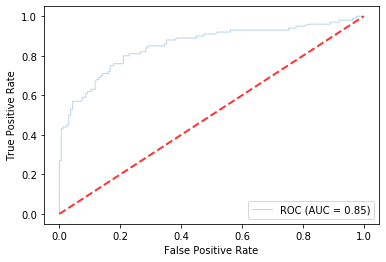

In [386]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

# sklearn.metrics.roc_auc_score(y_test, test_probs)

fig, ax = plt.subplots()
viz = metrics.plot_roc_curve(logisticRegr, X_test, y_test,
                         name='ROC',
                         alpha=0.3, lw=1, ax=ax)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**